<a href="https://colab.research.google.com/github/neelkanthrawat/Course_Computational_statistics_and_data_analysis/blob/main/Exercise_9_Heteroskedastic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
path='/content/data_09_x_y.csv'
df=pd.read_csv(path)

In [4]:
df

,x,y
0,-20.00000,-1.064822
1,-19.91992,-1.579783
2,-19.83984,-1.215242
3,-19.75976,-1.133058
4,-19.67968,-0.917498
...,...,...
995,59.67968,4.639976
996,59.75976,3.174017
997,59.83984,6.610470
998,59.91992,6.352328


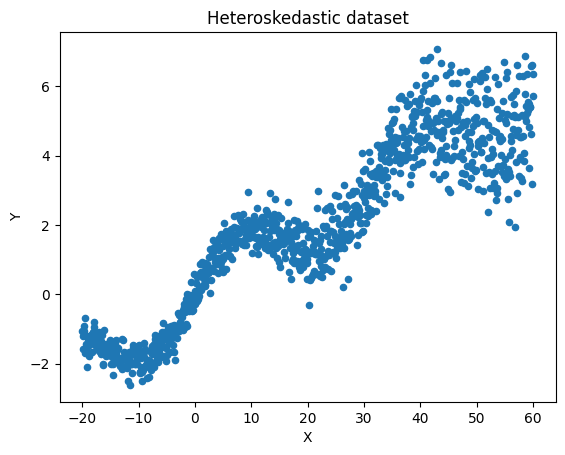

In [5]:
df.plot(x='x',y='y', kind='scatter')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heteroskedastic dataset')
plt.show()

In [6]:
xval, yval=df['x'].values, df['y'].values
xval.shape, yval.shape, type(yval)

((1000,), (1000,), numpy.ndarray)

In [7]:
xval, yval =np.array(xval).reshape(-1,1), np.array(yval).reshape(-1,1)
xval.shape, yval.shape

((1000, 1), (1000, 1))

In [8]:
random_state=42
x_train, x_test, y_train, y_test = train_test_split(xval, yval, test_size=0.33, random_state=random_state)

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((670, 1), (330, 1), (670, 1), (330, 1))

# 3.(b)

1. Creating a *MLP*

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_and_validate(model, train_loader, val_loader,device,
                       num_epochs=10, lr=0.001,
                       print_after=2):

    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #
    train_losses=[]
    val_losses=[]

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # save the losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % print_after == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} => Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    print("Training finished.")

    return train_losses, val_losses

In [12]:
# Create an instance of the MLP model
mlp_model = MLP()

# Print the architecture of the model
print(mlp_model)

MLP(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [13]:
class data_for_regression(torch.utils.data.Dataset):
  def __init__ (self, x, y):
    self.x=x
    self.y=y

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

In [14]:
### create the dataloaders

#1. converting to torch
x_trn_torch=torch.Tensor(x_train).float()
x_test_torch=torch.Tensor(x_test).float()
y_trn_torch=torch.Tensor(y_train).float()
y_test_torch=torch.Tensor(y_test).float()

train_dataset= data_for_regression(x_trn_torch, y_trn_torch)
test_dataset= data_for_regression(x_test_torch, y_test_torch)

batch_size=32
train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader= torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):

  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")

  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")

  if want_logscale:
    plt.yscale('log')
  plt.legend()

Epoch 100/1500 => Training Loss: 0.6917115265414828, Validation Loss: 0.7633940794251182
Epoch 200/1500 => Training Loss: 0.6794839614913577, Validation Loss: 0.6532000221989371
Epoch 300/1500 => Training Loss: 0.6771238105637687, Validation Loss: 0.6521012566306374
Epoch 400/1500 => Training Loss: 0.6759057839711508, Validation Loss: 0.6621691394935955
Epoch 500/1500 => Training Loss: 0.679789030835742, Validation Loss: 0.7363489053466103
Epoch 600/1500 => Training Loss: 0.669901328427451, Validation Loss: 0.6332195414738222
Epoch 700/1500 => Training Loss: 0.6768017318986711, Validation Loss: 0.6806525777686726
Epoch 800/1500 => Training Loss: 0.6519014693441845, Validation Loss: 0.7202168161218817
Epoch 900/1500 => Training Loss: 0.6045680855001722, Validation Loss: 0.6329956163059581
Epoch 1000/1500 => Training Loss: 0.5524846826280866, Validation Loss: 0.5387190905484286
Epoch 1100/1500 => Training Loss: 0.5096604710533506, Validation Loss: 0.5415547110817649
Epoch 1200/1500 => Tr

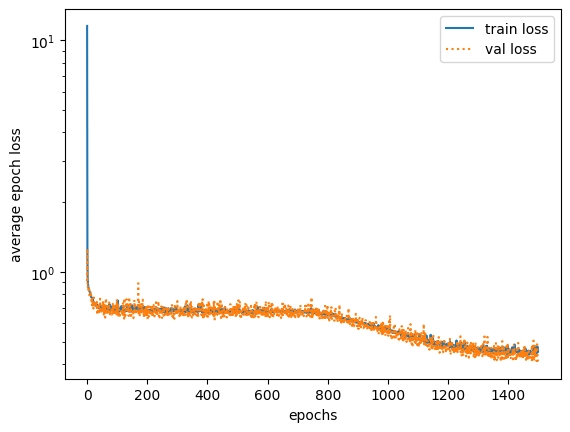

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_3b=MLP()

train_loss, test_loss=train_and_validate(model_3b,train_loader=train_dataloader,
                                         device=device,
                                         val_loader=tst_dataloader, num_epochs=1500, lr=0.0005,
                                         print_after=100)

plot_train_and_val_loss(train_loss, test_loss)

In [17]:
# Evaluate the model on the test set
model_3b.eval()
with torch.no_grad():
    y_test_pred = model_3b(x_test_torch.to(device))

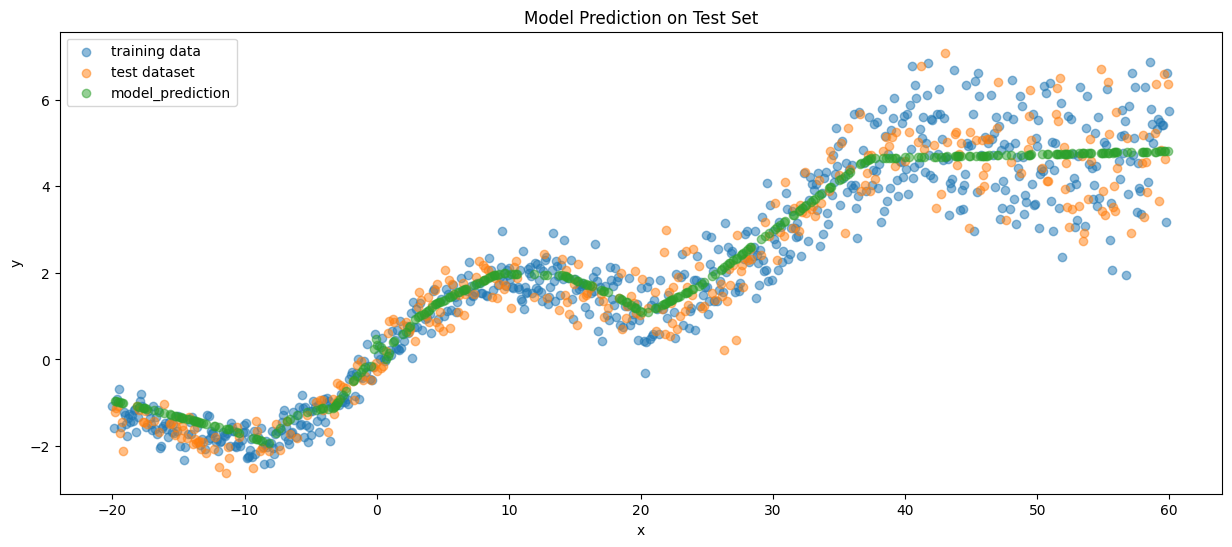

In [32]:
plt.figure(figsize=(15,6))
plt.scatter(x_train, y_train, label="training data", alpha=0.5)
plt.scatter(x_test, y_test, label="test dataset", alpha=0.5)
plt.scatter(x_test,y_test_pred.cpu().numpy(), label="model_prediction", alpha=0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Prediction on Test Set')
plt.show()

### 3(d)

In [19]:
class MLP_2(nn.Module):
    def __init__(self):
        super(MLP_2, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.relu2 = nn.ReLU()
        self.fc_mean = nn.Linear(64, 1)
        self.fc_variance= nn.Linear(64,1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        mean=self.fc_mean(x)
        var= torch.exp(self.fc_variance(x))# we exponentiated to ensure that that we get positive values of the variance
        return mean, var

In [20]:
# Define your custom loss function as a Python function
def custom_loss(outputs_from_model, y_true):
    # Separate the predicted mean and variance
    mean_pred, var_pred = outputs_from_model

    log_var_tensor = torch.log(var_pred)

    first_term_loss= (0.5)*torch.mean(log_var_tensor)
    second_term_loss= (0.5)* torch.mean((y_true-mean_pred)**2 / var_pred)
    total_loss= first_term_loss+ second_term_loss+ torch.tensor(np.log(2*np.pi)/2)
    return total_loss

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_and_validate_2(model, train_loader, val_loader,device,loss_fn,
                       num_epochs=10, lr=0.001,
                       print_after=2):

    model.to(device)

    criterion = loss_fn
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #
    train_losses=[]
    val_losses=[]

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # save the losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % print_after == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} => Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    print("Training finished.")

    return train_losses, val_losses

Epoch 100/1500 => Training Loss: 1.021526366495681, Validation Loss: 1.1165796972690798
Epoch 200/1500 => Training Loss: 0.9253443685550271, Validation Loss: 0.96115976238943
Epoch 300/1500 => Training Loss: 0.881758169072745, Validation Loss: 0.9341393215292019
Epoch 400/1500 => Training Loss: 0.8929268349019039, Validation Loss: 0.9403544170492214
Epoch 500/1500 => Training Loss: 0.8461220619458732, Validation Loss: 0.9048376456459954
Epoch 600/1500 => Training Loss: 0.7896835108832437, Validation Loss: 0.8476857861891528
Epoch 700/1500 => Training Loss: 0.7618480268213215, Validation Loss: 0.8845768375032467
Epoch 800/1500 => Training Loss: 0.7538931781571739, Validation Loss: 0.856913777293279
Epoch 900/1500 => Training Loss: 0.7461134720650661, Validation Loss: 0.8565374687870936
Epoch 1000/1500 => Training Loss: 0.7508979681226673, Validation Loss: 0.8093352121942562
Epoch 1100/1500 => Training Loss: 0.7426884430029765, Validation Loss: 0.8273442896131905
Epoch 1200/1500 => Train

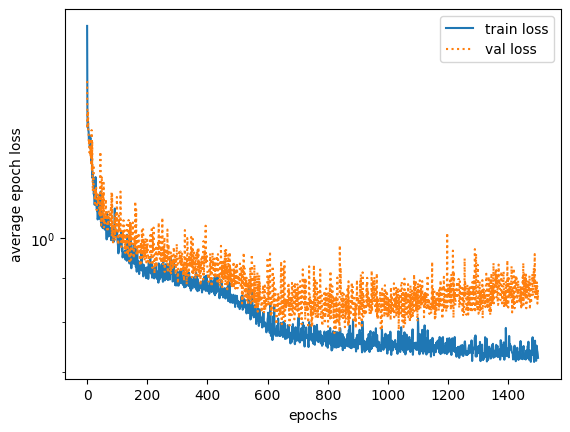

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_3d=MLP_2()# _3d for question number 3.d.

train_loss_3d, test_loss_3d=train_and_validate_2(model_3d,train_loader=train_dataloader,
                                         device=device,loss_fn=custom_loss,
                                         val_loader=tst_dataloader, num_epochs=1500, lr=0.0008,
                                         print_after=100)

plot_train_and_val_loss(train_loss_3d, test_loss_3d)

In [23]:
# Evaluate the model on the test set
model_3d.eval()
with torch.no_grad():
    mean_test_pred, var_test_pred = model_3d(x_test_torch.to(device))

In [24]:
# Convert predictions to numpy arrays
mean_test_pred_np = mean_test_pred.cpu().numpy()
var_test_pred_np = var_test_pred.cpu().numpy()

In [25]:
np.shape(mean_test_pred_np), np.shape(var_test_pred_np)

((330, 1), (330, 1))

In [26]:
var_test_pred_np  = np.squeeze(var_test_pred_np)
mean_test_pred_np = np.squeeze(mean_test_pred_np)

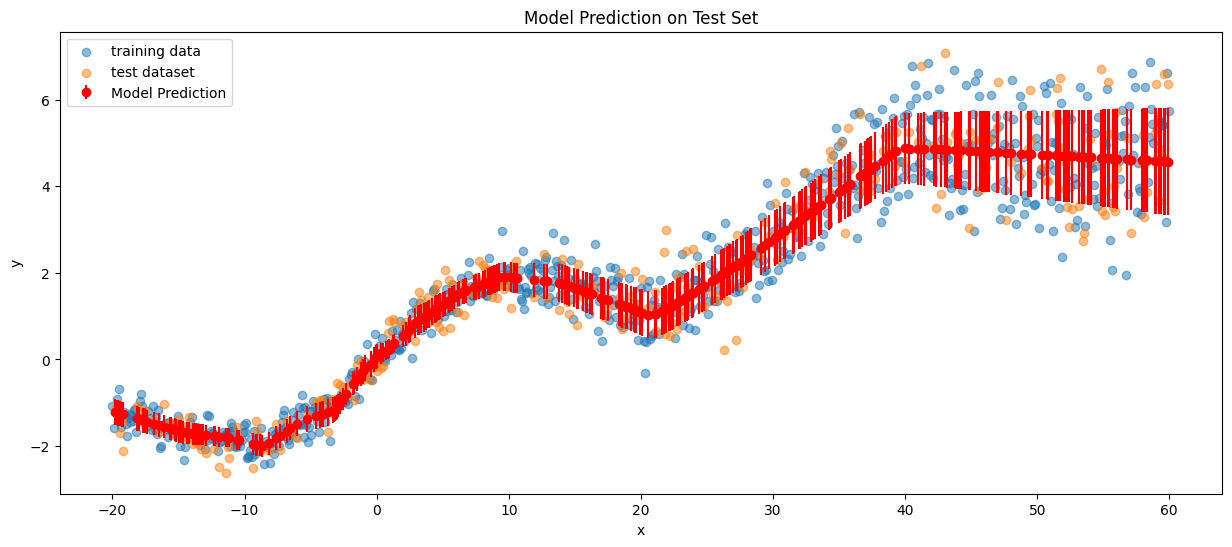

In [33]:
plt.figure(figsize=(15,6))
plt.scatter(x_train, y_train, label="training data", alpha=0.5)
plt.scatter(x_test, y_test, label="test dataset", alpha=0.5)
plt.errorbar(x_test, mean_test_pred_np, yerr=np.sqrt(var_test_pred_np),
             label='Model Prediction', fmt="o", color="red")

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Prediction on Test Set')
plt.show()